## Trabalho Pr√°tico 3 - Explora√ß√£o e Mapeamento

### Importando as bibliotecas

In [16]:
import numpy as np
import time
import random as rd
import matplotlib.pyplot as plt
from skimage.draw import line

from coppeliasim_zmqremoteapi_client import *


## Remote API functions (Python)

Cria√ß√£o do cliente para conex√£o com a api remota

Link para reposit√≥rio da SimZMQRemoteApi: https://github.com/CoppeliaRobotics/zmqRemoteApi/tree/master/clients/python


In [17]:
# create a client to connect to zmqRemoteApi server:
# (creation arguments can specify different host/port,
# defaults are host='localhost', port=23000)
client = RemoteAPIClient()

# get a remote object:
sim = client.require('sim')

# call API function fo test:
Rack = sim.getObject('/rack')
print("Printando algo em cena: " + str(Rack))

Printando algo em cena: 36


### Occupancy Grid

A manipula√ß√£o direta das probabilidades pode ser dif√≠cil:
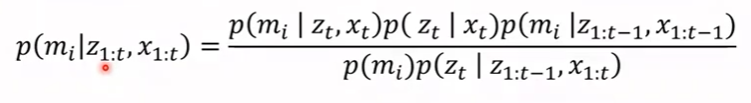

Uma forma de simplificar √© usar a raz√£o das probabil√ßidades. Essa tamb√©m √© uma maneira de assosciar os eventos (occ, free)

Evento OCC -> Ocupado:
Indica que a  c√©lula na grade est√° ocupada por um obst√°culo. A probabilidade de ocupa√ß√£o 
ùëÉ
(
ùëÇ
ùëñ
‚à£
ùëç
)
P(O 
i
‚Äã
 ‚à£Z) √© atualizada para refletir a presen√ßa de um obst√°culo, com uma probabilidade maior de estar ocupada.

Evento free -> Livre:
Indica que uma c√©lula na grade est√° livre de obst√°culos. A probabilidade de ocupa√ß√£o 
ùëÉ
(
ùëÇ
ùëñ
‚à£
ùëç
)
P(O 
i
‚Äã
 ‚à£Z) √© atualizada para refletir a aus√™ncia de um obst√°culo, com uma probabilidade menor de estar ocupada.

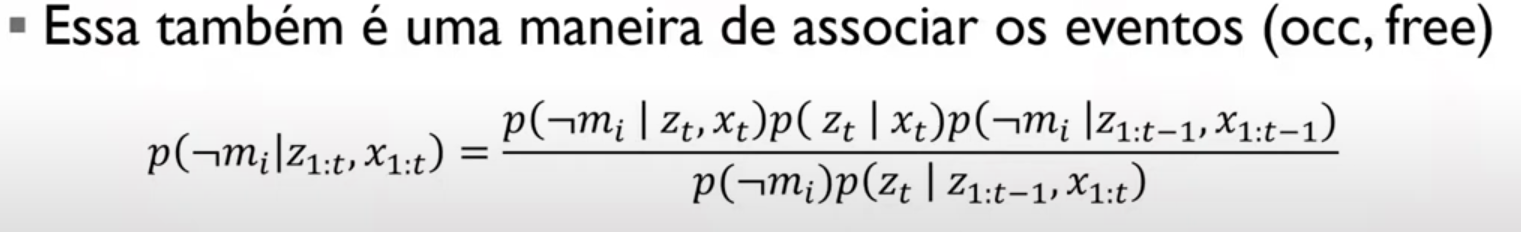

A arte-manha para simplificar o c√°lculo dessas probabilidades. Trabalhamos com a raz√£o entre a probabilidade e a n√£o probabilidade.

Com isso passamos a trabalhar com a probabilidade Odds, ou chances: (p(a) -> o(a) e vice-versa)
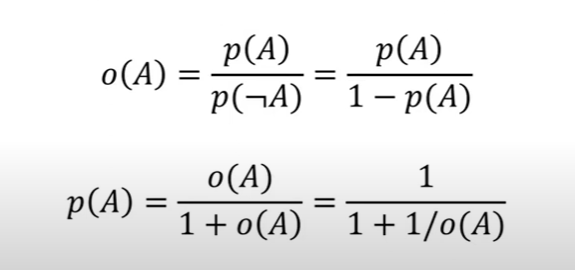

Juntando a chance com a probabilidade e manipulando um pouco as equa√ß√µes temos que a chance dela estar ocupada(Utiliza Zt) sendo igual a informa√ß√£o da nossa leitura vezes a probabilidade anterior p(occ) em t - 1, vezes toda a informa√ß√£o do mapa (prior).
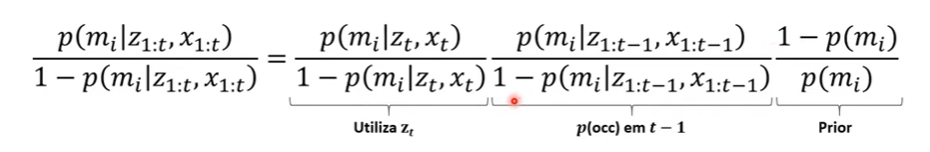

O log-odds √© utilizado para evitar truncamento pela multiplica√ß√£o de probabilidades. Ou seja, evita a informa√ß√£o perdida nos m√∫ltiplos truncamentos.
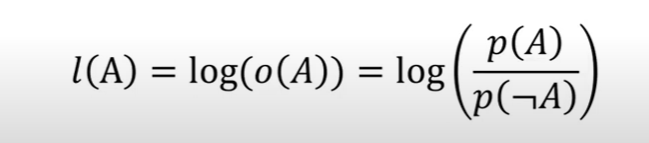

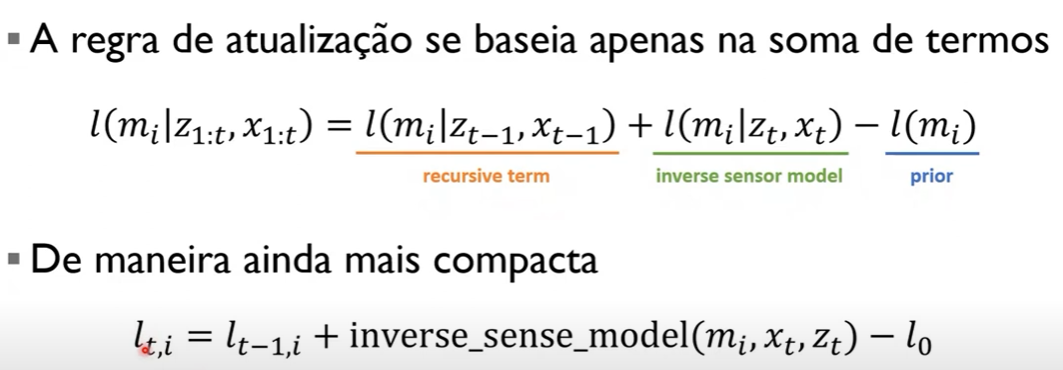

O algoritmo de mapeamento completo fica:
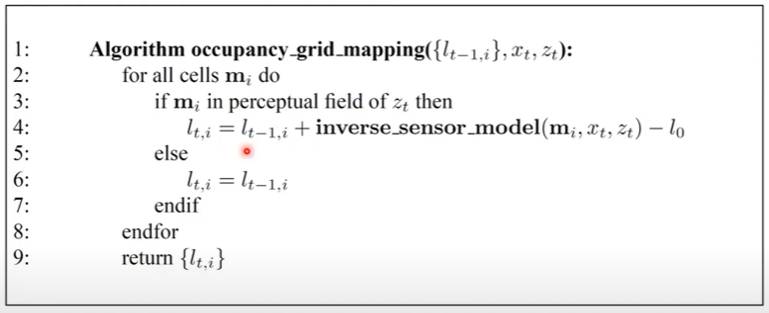

O Inverse vem para modelar ou representar como uma nova leitura acrescenta em rela√ß√£o ao prior. Abaixo tem oalgortimo em um sonar. 
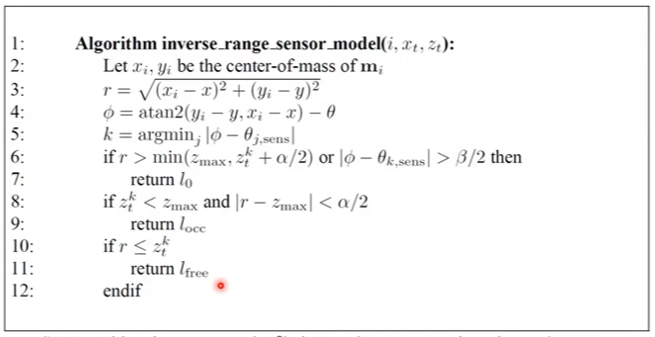

Modelo de Observa√ß√£o
Modela senbsores com v√°rias leituras simult√¢neamente.

In [12]:
# Par√¢metros do grid de ocupa√ß√£o
map_size = [10, 10]  # Tamanho do mapa em metros
cell_size = 0.1  # Tamanho da c√©lula em metros
rows, cols = int(map_size[0] / cell_size), int(map_size[1] / cell_size)  # N√∫mero de linhas e colunas

# Inicializa√ß√£o do occupancy grid
occupancy_grid = np.full((rows, cols), 0.5)  # Valor inicial 0.5 para representar c√©lulas desconhecidas

def log_odds(p):
    return np.log(p / (1 - p))

def inv_log_odds(l):
    return 1 - (1 / (1 + np.exp(l)))
# Atualiza a probabilidade de uma c√©lula
def update_cell(prob, log_odds):
    return inv_log_odds(log_odds + log_odds(prob))

# C√°lculo do inverse sensor model
def inverse_range_sensor_model(cel, cel_robot, max_distance, prob):
    max = max_distance/cell_size
    alpha = 0.2/cell_size
    distanceObs = np.linalg.norm(cel - cel_robot[:2])
    pocc = 0.85
    pfree = 0.1
    locc = log_odds(pocc)
    lfree = log_odds(pfree)
    if distanceObs > min(max, max_distance + alpha/2):
        return log_odds(prob)
    if max_distance < max and abs(distanceObs - max_distance) <= alpha/2:
        return locc
    if distanceObs <= max_distance:
        return lfree

def occupancy_grid_mapping2(cel_robo, cel_final, occupancy_grid):
    distanceMax = np.linalg.norm(cel_robo - cel_final)
    rr, cc = line(cel_robo[0], cel_robo[1], cel_final[0], cel_final[1])
    for i in range(len(rr)):
        cel_prob = occupancy_grid[rr[i], cc[i]]
        l_ant = log_odds(cel_prob)
        cel = np.array([rr[i], cc[i]])
        l_cell = l_ant + inverse_range_sensor_model(cel, cel_robo, distanceMax, cel_prob)
        occupancy_grid[rr[i], cc[i]] = inv_log_odds(l_cell)
    return occupancy_grid

def plot_occupancy_grid(occupancy_grid, cols, rows, cell_size):
    # Fun√ß√£o para plotar o grid de ocupa√ß√£o
    fig = plt.figure(figsize=(8,8), dpi=100)
    
    ax = fig.add_subplot(111, aspect='equal')
    
    m = 1 - 1 / (1 + np.exp(occupancy_grid))
    
    plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))
    ax.set_xticks(np.arange(0, cols, cell_size))
    ax.set_yticks(np.arange(0, rows, cell_size))

    
    plt.colorbar()
    ax = plt.gca()
    ax.set_xticks(ax.get_ylim()[::-1])
    
def plot_laser_points(laser_data, robot_pos, robot_ori, map_size, cell_size):
    # Fun√ß√£o para plotar os pontos do laser
    fig = plt.figure(figsize=(8,8), dpi=100)
    
    ax = fig.add_subplot(111, aspect='equal')
    
    Hlw = transformacaoLaser(robot_pos, robot_ori)
    
    for point in laser_data:
        point_homogeneous = np.array([point[0], point[1], 0, 1])
        point_transformed = Hlw @ point_homogeneous
        point_map = [(point_transformed[0] + map_size[0] / 2) / cell_size, 
                     (point_transformed[1] + map_size[1] / 2) / cell_size]
        
        plt.plot(point_map[0], point_map[1], 'ro')
    
    plt.xlim([0, map_size[0] / cell_size])
    plt.ylim([0, map_size[1] / cell_size])
    
    plt.show()

def transformacaoLaser(pos, ori):
    # Fun√ß√£o para calcular a matriz de transforma√ß√£o homog√™nea do rob√¥ para o mundo
    theta = ori[2]
    transform = np.array([
        [np.cos(theta), -np.sin(theta), 0, pos[0]],
        [np.sin(theta), np.cos(theta), 0, pos[1]],
        [0, 0, 1, pos[2]],
        [0, 0, 0, 1]
    ])
    return transform
    

### Leitura dos sensores

In [13]:
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):
    
    string_range_data = sim.getStringSignal(range_data_signal_id)

    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # verifique se ambos os dados foram obtidos corretamente
    if string_range_data != None and string_angle_data != None:
        # descompacte dados de mensagens de alcance e sensor
        raw_range_data = sim.unpackFloatTable(string_range_data)
        raw_angle_data = sim.unpackFloatTable(string_angle_data)

        return raw_range_data, raw_angle_data
    else:
        return np.array([]), np.array([])

def get_all_laser_data_ruido(laser_data, trans_global):
    dados_ruidos = []
    for ang, dist in laser_data:
        if dist < 5:  # Considerando leituras v√°lidas do laser
            x = dist * np.cos(ang) + rd.uniform(-0.05, 0.05)  # Adicionando ru√≠do na coordenada x
            y = dist * np.sin(ang) + rd.uniform(-0.05, 0.05)  # Adicionando ru√≠do na coordenada y
            ponto_global = trans_global @ np.array([x, y, 1])
            dados_ruidos.append([ponto_global[0], ponto_global[1]])
    return dados_ruidos
    

In [18]:
# Fun√ß√£o para rotacionar em torno do eixo z
def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

def get_object_position(sim, object_name):
    return sim.getObjectPosition(sim.getObject(object_name), -1)

def get_object_orientation(sim, object_name):
    return sim.getObjectOrientation(sim.getObject(object_name), -1)

def transformacao(posA, oriA):
    # Cria√ß√£o da matriz de transforma√ß√£o homog√™nea
    RWA = Rz(oriA[2])

    TWA = np.array([[posA[0]], [posA[1]], [posA[2]]]) # Transforma a posi√ß√£o em um array

    # Adiciona uma linha [0, 0, 0, 1] √† direita da matriz RWA
    HWA = np.column_stack((RWA, TWA))
    HWA = np.row_stack((HWA, [0, 0, 0, 1]))  # Adiciona a linha [0, 0, 0, 1] ao final da matriz HWA

    return HWA

class RobotController:
    def __init__(self, robot_name):
        self.client = RemoteAPIClient()
        self.sim = self.client.getObject('sim')
        self.robot = self.sim.getObject(f'/{robot_name}') 
        self.laser = self.sim.getObject('/fastHokuyo')
        self.robot_name = robot_name
        self.robot_handle = self.sim.getObjectHandle(f'/{robot_name}')
        self.left_wheel = self.sim.getObjectHandle(f'/{robot_name}_leftMotor')
        self.right_wheel = self.sim.getObjectHandle(f'/{robot_name}_rightMotor')
        self.goal_handle = self.sim.getObjectHandle('/ReferenceFrame')
        self.path = []  # Para armazenar o caminho do rob√¥
        self.laser_points = []  # Para armazenar os pontos do laser

    # Fun√ß√£o para iniciar a simula√ß√£o
    def start_simulation(self):
        self.sim.startSimulation()

    # Fun√ß√£o para parar a simula√ß√£o
    def stop_simulation(self):
        self.sim.stopSimulation()

    # Fun√ß√£o para retornar a posi√ß√£o do robo
    def get_robot_position(self):
        return self.sim.getObjectPosition(self.robot, -1)

    # Fun√ß√£o para retornar a orienta√ß√£o do robo
    def get_robot_orientation(self):
        return self.sim.getObjectOrientation(self.robot, -1)
    
    # Fun√ß√£o para setar a orienta√ß√£o do robo
    def set_robot_orientation(self, orientation):
        self.sim.setObjectOrientation(self.robot, -1, orientation)

    # Fun√ß√£o para setar a velocidade na roda esquerda do robo
    def set_left_wheel_velocity(self, velocity):
        self.sim.setJointTargetVelocity(self.left_wheel, velocity)

    # Fun√ß√£o para setar a velocidade na roda direita do robo
    def set_right_wheel_velocity(self, velocity):
        self.sim.setJointTargetVelocity(self.right_wheel, velocity)
        
    def get_laser_data(self):
        return readSensorData(self.sim)
    
    def set_goal_position(self, position):
        self.sim.setObjectPosition(self.goal_handle, -1, position)
        
    def update_path(self):
        robot_pos = self.get_robot_position()
        self.path.append(robot_pos)

    def update_laser_points(self, laser_data):
        for point in laser_data:
            self.laser_points.append(point)


In [15]:
def att_force(q, goal, katt = 5):
  Fatt = katt *(goal - q)
  return Fatt

def rep_force(q, obs, R=1, krep = 0.002):
    Frep = np.zeros(2)
    for obstacle in obs:
        v = q[0:2] - obstacle
        d = np.linalg.norm(v) 

        # Se a dist√¢ncia for menor que o raio de influ√™ncia	calcular a for√ßa repulsiva
        if (d < R):  
            rep = (1/d**2)*((1/d)-(1/R))*(v/d) 
            Frep += rep

    return krep*Frep

def tt_force(q,goal,laser_data,obs,obs_pts,HWL, max_sensor_range = 5):
    Frep = np.zeros(2)
    for i in range(len(laser_data)):
        ang, dist = laser_data[i] #pega os valores de angulo e dist√¢ncia

        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang) #meu x
            y = dist * np.sin(ang) #meu y
            point = np.array([x,y,0,1])

            if len(HWL) != 0:
                point = HWL @ point
                obs.append(point[0:2])
                obs_pts.append(point)  
    Frep = rep_force(q, obs)
    Fatt= att_force(q, goal)
    Ft = Fatt + Frep
            
    return [Ft, Fatt, Frep]


In [21]:
def laser_to_cell(laser_data, robot_pos, robot_ori, map_size, cell_size):
    Hlw = transformacaoLaser(robot_pos, robot_ori)
    laser_data_total = []
    for point in laser_data:
        point_homogeneous = np.array([point[0], point[1], 0, 1])
        point_transformed = Hlw @ point_homogeneous
        point_map = [(point_transformed[0] + map_size[0] / 2) / cell_size, 
                     (point_transformed[1] + map_size[1] / 2) / cell_size]
        laser_data_total.append(point_map)
    return laser_data_total

# Par√¢metros do grid de ocupa√ß√£o
map_size = [10, 10]  # Tamanho do mapa em metros
cell_size = 0.1  # Tamanho da c√©lula em metros
rows, cols = int(map_size[0] / cell_size), int(map_size[1] / cell_size)  # N√∫mero de linhas e colunas

# Inicializa√ß√£o do occupancy grid
occupancy_grid = np.full((rows, cols), 0.5)  # Valor inicial 0.5 para representar c√©lulas desconhecidas

# Conectando-se ao CoppeliaSim
clientID = sim.startSimulation()

if clientID != -1:
    print('Program Started')
    
    robot_controller = RobotController('kobuki')

    robot_controller.start_simulation()
    robot_pos = robot_controller.get_robot_position()
    robot_ori = robot_controller.get_robot_orientation()

    goal_position = [-2.4, -2.45, 0]  # Posi√ß√£o inicial do objetivo
    robot_controller.set_goal_position(goal_position)
    
    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"
    
    distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))
    
    robot_path = []
    laser_data_total = []
    
    while distance_goal > 0.5:
        # Leitura do laser
        if laser_range_data is not None and laser_angle_data is not None:
            raw_range_data, raw_angle_data = readSensorData() 
            
        laser_data = np.array([raw_angle_data, raw_range_data]).T
    
        laser_transform = Rz(np.pi / 2)
        noisy_data = get_all_laser_data_ruido(laser_data, laser_transform)

        # Atualizando robo
        robot_pos = robot_controller.get_robot_position()
        robot_ori = robot_controller.get_robot_orientation()
        
        robot_path.append(robot_pos)
        
        for i in range(len(laser_data)):# Para cada feixe do laser
            # fim_laser = Rz(np.pi/2) @ [(np.array(laser_data[i][0]) + map_size[0]/2), (np.array(laser_data[i][1]) + map_size[1]/2), 0]
            # robo_mapa = Rz(np.pi/2) @ [(robot_pos[0] + map_size[0]/2), (robot_pos[1] + map_size[1]/2), 0]
            # max_cel = len(occupancy_grid) - 1
            # robot_x = min(max_cel, (robo_mapa[0]/cell_size).astype(int)) # posicao x do robo na celula do mapa occ grid
            # robot_y = min(max_cel, (robo_mapa[1]/cell_size).astype(int)) # posicao y do robo na celula do mapa occ grid
            # celula_x = min(max_cel, (fim_laser[0]/cell_size).astype(int)) # posicao x do laser na celula do mapa occ grid
            # celula_y = min(max_cel, (fim_laser[1]/cell_size).astype(int))
            point = np.append(point[:3], 1)  # Ensure point has a size of 4
            point = laser_transform @ point
            
            ang, dist = laser_data[i] # pega os valores de angulo e dist√¢ncia
            if (5 - dist) > 0.1:
                x = dist * np.cos(ang)
                y = dist * np.sin(ang)
                point = np.array([x, y, 0, 1])
                
                if len(laser_transform) != 0:
                    point = laser_transform @ point
                    obs.append(point[0:2])
                    obs_pts.append(point)
                    occupancy_grid = occupancy_grid_mapping2(np.array([robot_pos[0], robot_pos[1]]), np.array([laser_x, laser_y]), occupancy_grid)
            
            laser_data_total.append(laser_data[i])
            
            occupancy_grid = occupancy_grid_mapping2(np.array([robot_x, robot_y]), np.array([celula_x, celula_y]), occupancy_grid)
        
        Hlw = transformacao(robot_pos, robot_ori) # Matriz de transforma√ß√£o do laser para o mundo
        
        obs = [] # Lista de obst√°culos
        obs_pts = [] # Lista de pontos dos obst√°culos
        
        # Calculando for√ßas
        Ft, Fatt, Frep = tt_force(np.array(robot_pos[:2]), np.array(goal_position[:2]), laser_data, obs, obs_pts, Hlw)
            
        dx, dy = Ft

        kr = 0.05
        kt = 0.1

        v = kr * (dx * np.cos(robot_ori[2]) + dy * np.sin(robot_ori[2]))
        w = kt * (np.arctan2(dy, dx) - robot_ori[2])

        v = max(min(v, 0.2), -0.2)
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))

        vr = (2 * v + 0.23 * w) / (2 * 0.035)
        vl = (2 * v - 0.23 * w) / (2 * 0.035)
        

        # Envia velocidades calculadas
        robot_controller.set_left_wheel_velocity(vl)
        robot_controller.set_right_wheel_velocity(vr)

        distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))

    robot_controller.set_left_wheel_velocity(0)
    robot_controller.set_right_wheel_velocity(0)
    #robot_controller.stop_simulation()
    print('Program ended')
    
    plot_occupancy_grid(occupancy_grid, cols, rows, cell_size)
    plot_laser_points(laser_data_total, robot_pos, robot_ori, map_size, cell_size)

Program Started


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

Program Started


C:\Users\felip\AppData\Local\Temp\ipykernel_11084\372765575.py:10: RuntimeWarning: divide by zero encountered in log
  return np.log(p / (1 - p))
C:\Users\felip\AppData\Local\Temp\ipykernel_11084\372765575.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(p / (1 - p))


Program ended


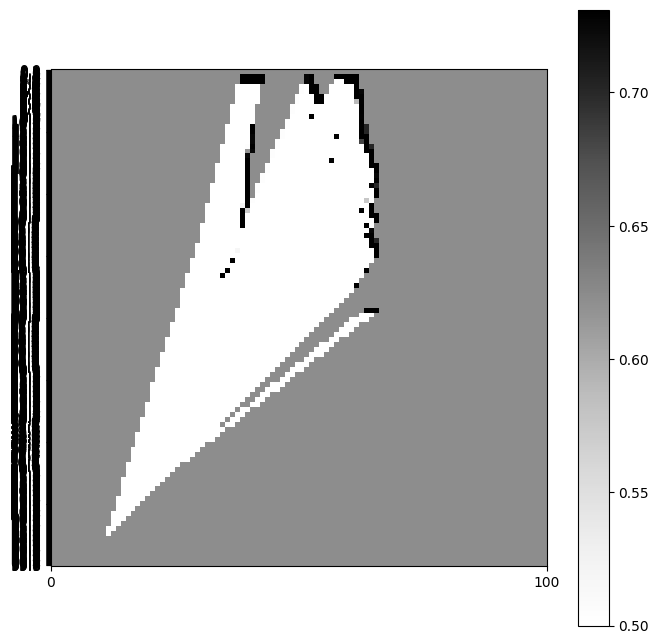

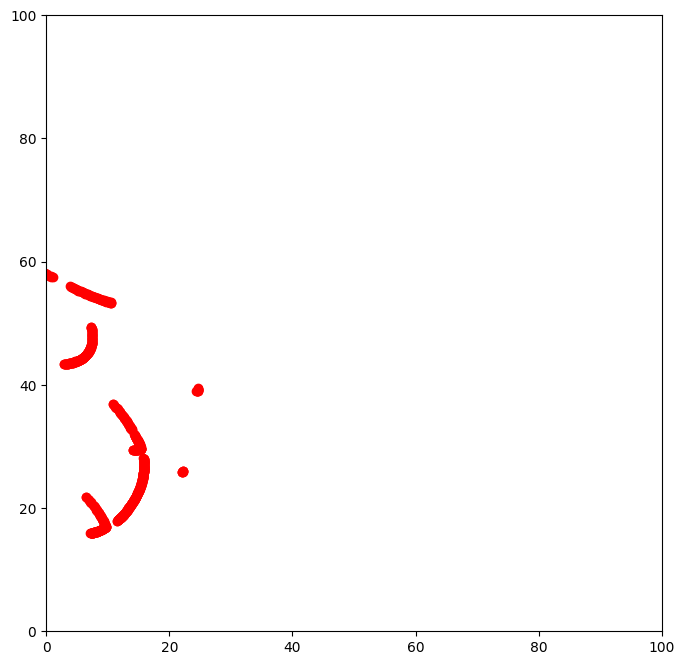

In [9]:
def laser_to_grid(robot_pos, robot_ori, laser_data, grid_size, cell_size):
    """
    Converte as leituras do laser em c√©lulas do occupancy grid.

    Parameters:
    - robot_pos: Posi√ß√£o do rob√¥ (x, y, z)
    - robot_ori: Orienta√ß√£o do rob√¥ (roll, pitch, yaw)
    - laser_data: Dados do laser [(dist√¢ncia, √¢ngulo), ...]
    - grid_size: Tamanho do grid (rows, cols)
    - cell_size: Tamanho da c√©lula no grid

    Returns:
    - grid_cells: Lista de c√©lulas ocupadas no grid [(row, col), ...]
    """
    grid_cells = []
    robot_x, robot_y, robot_z = robot_pos
    _, _, robot_yaw = robot_ori
    
    for distance, angle in laser_data:
        # Convertendo coordenadas polares para cartesianas
        x_laser = distance * np.cos(angle)
        y_laser = distance * np.sin(angle)

        # Rotacionando as coordenadas do laser para alinhar com a orienta√ß√£o do rob√¥
        x_world = x_laser * np.cos(robot_yaw) - y_laser * np.sin(robot_yaw)
        y_world = x_laser * np.sin(robot_yaw) + y_laser * np.cos(robot_yaw)

        # Convertendo para coordenadas globais
        x_global = x_world + robot_x
        y_global = y_world + robot_y

        # Convertendo para c√©lulas do grid
        cell_x = int(x_global / cell_size)
        cell_y = int(y_global / cell_size)
        
        if 0 <= cell_x < grid_size[1] and 0 <= cell_y < grid_size[0]:
            grid_cells.append((cell_y, cell_x))
    
    return grid_cells

# Fun√ß√£o para calcular o √¢ngulo em rela√ß√£o ao objetivo
def angle_to_goal(robot_pos, goal_pos):
    dx = goal_pos[0] - robot_pos[0]
    dy = goal_pos[1] - robot_pos[1]
    return np.arctan2(dy, dx)

# Fun√ß√£o para girar o rob√¥ para a dire√ß√£o do objetivo
def orient_towards_goal(robot_controller, goal_angle):
    while True:
        robot_ori = robot_controller.get_robot_orientation()
        current_angle = robot_ori[2]
        angle_diff = goal_angle - current_angle
        
        if abs(angle_diff) < np.deg2rad(5):  # Considera a orienta√ß√£o correta se a diferen√ßa for menor que 5 graus
            break

        w = 0.1 * angle_diff  # Proporcional ao erro angular
        
        # Limita a velocidade angular para garantir uma rota√ß√£o suave
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))
        
        vr = 0.23 * w / (2 * 0.035)
        vl = -0.23 * w / (2 * 0.035)

        robot_controller.set_left_wheel_velocity(vl)
        robot_controller.set_right_wheel_velocity(vr)

# Conectando-se ao CoppeliaSim
clientID = sim.startSimulation()

if clientID != -1:
    print('Program Started')
    # guardar a trajet√≥ria do rob√¥
    robot_path = []
    
    robot_controller = RobotController('kobuki')

    robot_controller.start_simulation()
    robot_pos = robot_controller.get_robot_position()
    robot_ori = robot_controller.get_robot_orientation()

    goal_position = [-2.4, -2.45, 0]  # Posi√ß√£o inicial do objetivo
    robot_controller.set_goal_position(goal_position)
    
    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"
    
    distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))
    
    # Calcula o √¢ngulo para o objetivo e orienta o rob√¥
    goal_angle = angle_to_goal(robot_pos, goal_position)
    orient_towards_goal(robot_controller, goal_angle)
    
    while distance_goal > 0.5:
        # Leitura do laser
        if laser_range_data is not None and laser_angle_data is not None:
            raw_range_data, raw_angle_data = readSensorData() 
            
        laser_data = np.array([raw_angle_data, raw_range_data]).T
    
        laser_transform = Rz(np.pi / 2)
        noisy_data = get_all_laser_data_ruido(laser_data, laser_transform)
        
        laser_data_total = []
        obs = [] # Lista de obst√°culos
        obs_pts = [] # Lista de pontos dos obst√°culos

        # Atualizando robo
        robot_pos = robot_controller.get_robot_position()
        robot_ori = robot_controller.get_robot_orientation()
        
        robot_path.append(robot_pos)
        
        # Transformar matriz de transforma√ß√£o do laser para o mundo
        Hlw = transformacaoLaser(robot_pos, robot_ori)  
        
        for i in range(len(laser_data)):
            ang, dist = laser_data[i] # pega os valores de angulo e dist√¢ncia
            if (5 - dist) > 0.1: # 5 = max_sensor_range
                x = dist * np.cos(ang)
                y = dist * np.sin(ang)
                point = np.array([x, y, 0, 1])
                
                if len(Hlw) != 0:
                    point = Hlw @ point
                    obs.append(point[0:2])
                    obs_pts.append(point)
                    
                
            fim_laser = Rz(np.pi/2) @ [(np.array(laser_data[i][0]) + map_size[0]/2), (np.array(laser_data[i][1]) + map_size[1]/2), 0]
            robo_mapa = Rz(np.pi/2) @ [(robot_pos[0] + map_size[0]/2), (robot_pos[1] + map_size[1]/2), 0]
            max_cel = len(occupancy_grid) - 1
            robot_x = min(max_cel, (robo_mapa[0]/cell_size).astype(int)) # posicao x do robo na celula do mapa occ grid
            robot_y = min(max_cel, (robo_mapa[1]/cell_size).astype(int)) # posicao y do robo na celula do mapa occ grid
            celula_x = min(max_cel, (fim_laser[0]/cell_size).astype(int)) # posicao x do laser na celula do mapa occ grid
            celula_y = min(max_cel, (fim_laser[1]/cell_size).astype(int))
            
            # transformar o laser em rela√ß√£o ao mundo
            
            laser_data_total.append(laser_data[i])
            
            occupancy_grid = occupancy_grid_mapping2(np.array([robot_x, robot_y]), np.array([celula_x, celula_y]), occupancy_grid)
        
        Hlw = transformacao(robot_pos, robot_ori) # Matriz de transforma√ß√£o do laser para o mundo
        

        
        # Calculando for√ßas
        Ft, Fatt, Frep = tt_force(np.array(robot_pos[:2]), np.array(goal_position[:2]), laser_data, obs, obs_pts, Hlw)
            
        dx, dy = Ft

        kr = 0.05
        kt = 0.1

        v = kr * (dx * np.cos(robot_ori[2]) + dy * np.sin(robot_ori[2]))
        w = kt * (np.arctan2(dy, dx) - robot_ori[2])

        v = max(min(v, 0.2), -0.2)
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))

        vr = (2 * v + 0.23 * w) / (2 * 0.035)
        vl = (2 * v - 0.23 * w) / (2 * 0.035)
        

        # Envia velocidades calculadas
        robot_controller.set_left_wheel_velocity(vl)
        robot_controller.set_right_wheel_velocity(vr)

        distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))

    robot_controller.set_left_wheel_velocity(0)
    robot_controller.set_right_wheel_velocity(0)
    robot_controller.stop_simulation()
    print('Program ended')
    
    plot_occupancy_grid(occupancy_grid, cols, rows, cell_size)
    plot_laser_points(laser_data_total, robot_pos, robot_ori, map_size, cell_size)


In [25]:
import numpy as np
from skimage.draw import line
import time

# Fun√ß√£o para rotacionar em torno do eixo z
def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

def log_odds(p):
    return np.log(p / (1 - p))

def inv_log_odds(l):
    return 1 - (1 / (1 + np.exp(l)))

# Atualiza a probabilidade de uma c√©lula
def update_cell(prob, log_odds):
    return inv_log_odds(log_odds + log_odds(prob))

# C√°lculo do inverse sensor model
def inverse_range_sensor_model(cel, cel_robot, max_distance, prob):
    max_dist = max_distance / cell_size
    alpha = 0.2 / cell_size
    distanceObs = np.linalg.norm(cel - cel_robot[:2])
    pocc = 0.85
    pfree = 0.1
    locc = log_odds(pocc)
    lfree = log_odds(pfree)
    if distanceObs > min(max_dist, max_distance + alpha / 2):
        return log_odds(prob)
    if max_distance < max_dist and abs(distanceObs - max_distance) <= alpha / 2:
        return locc
    if distanceObs <= max_distance:
        return lfree

def occupancy_grid_mapping2(cel_robo, cel_final, occupancy_grid):
    distanceMax = np.linalg.norm(cel_robo - cel_final)
    rr, cc = line(cel_robo[0], cel_robo[1], cel_final[0], cel_final[1])
    for i in range(len(rr)):
        cel_prob = occupancy_grid[rr[i], cc[i]]
        l_ant = log_odds(cel_prob)
        cel = np.array([rr[i], cc[i]])
        l_cell = l_ant + inverse_range_sensor_model(cel, cel_robo, distanceMax, cel_prob)
        occupancy_grid[rr[i], cc[i]] = inv_log_odds(l_cell)
    return occupancy_grid

# Fun√ß√£o para calcular o √¢ngulo em rela√ß√£o ao objetivo
def angle_to_goal(robot_pos, goal_pos):
    dx = goal_pos[0] - robot_pos[0]
    dy = goal_pos[1] - robot_pos[1]
    return np.arctan2(dy, dx)

# Fun√ß√£o para girar o rob√¥ para a dire√ß√£o do objetivo
def orient_towards_goal(robot_controller, goal_angle):
    while True:
        robot_ori = robot_controller.get_robot_orientation()
        current_angle = robot_ori[2]
        angle_diff = goal_angle - current_angle
        
        if abs(angle_diff) < np.deg2rad(5):  # Considera a orienta√ß√£o correta se a diferen√ßa for menor que 5 graus
            break

        w = 0.1 * angle_diff  # Proporcional ao erro angular
        
        # Limita a velocidade angular para garantir uma rota√ß√£o suave
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))
        
        vr = 0.23 * w / (2 * 0.035)
        vl = -0.23 * w / (2 * 0.035)

        robot_controller.set_left_wheel_velocity(vl)
        robot_controller.set_right_wheel_velocity(vr)

# Fun√ß√£o para detectar obst√°culos usando os dados do laser
def detect_obstacles(laser_data, threshold=0.5):
    # Verifica se existe algum obst√°culo dentro do limite de dist√¢ncia
    for distance in laser_data[:, 1]:
        if distance < threshold:
            return True
    return False

# Fun√ß√£o para encontrar uma nova dire√ß√£o livre de obst√°culos
def find_new_direction(robot_controller, laser_data, current_angle):
    num_angles = 36  # N√∫mero de √¢ngulos a serem verificados (360/10)
    for i in range(num_angles):
        angle = current_angle + (i * np.deg2rad(10))
        angle = angle % (2 * np.pi)  # Garante que o √¢ngulo esteja entre 0 e 2pi
        
        robot_controller.set_robot_orientation([0, 0, angle])  # Muda a orienta√ß√£o do rob√¥
        # Aguarda um tempo para o rob√¥ ajustar sua orienta√ß√£o
        time.sleep(0.5)
        
        # Verifica os dados do laser na nova orienta√ß√£o
        raw_range_data, raw_angle_data = readSensorData()
        new_laser_data = np.array([raw_angle_data, raw_range_data]).T
        
        # Se n√£o houver obst√°culos na nova dire√ß√£o, retorna o novo √¢ngulo
        if not detect_obstacles(new_laser_data):
            return angle
    return current_angle  # Se n√£o encontrar uma dire√ß√£o livre, retorna o √¢ngulo atual

# Fun√ß√£o para obter a posi√ß√£o de um objeto
def get_object_position(sim, object_name):
    return sim.getObjectPosition(sim.getObject(object_name), -1)

# Fun√ß√£o para obter a orienta√ß√£o de um objeto
def get_object_orientation(sim, object_name):
    return sim.getObjectOrientation(sim.getObject(object_name), -1)

# Fun√ß√£o para criar a matriz de transforma√ß√£o homog√™nea
def transformacao(posA, oriA):
    RWA = Rz(oriA[2])
    TWA = np.array([[posA[0]], [posA[1]], [posA[2]]]) # Transforma a posi√ß√£o em um array
    HWA = np.column_stack((RWA, TWA))
    HWA = np.row_stack((HWA, [0, 0, 0, 1]))  # Adiciona a linha [0, 0, 0, 1] ao final da matriz HWA
    return HWA

class RobotController:
    def __init__(self, robot_name):
        self.client = RemoteAPIClient()
        self.sim = self.client.getObject('sim')
        self.robot = self.sim.getObject(f'/{robot_name}') 
        self.laser = self.sim.getObject('/fastHokuyo')
        self.robot_name = robot_name
        self.robot_handle = self.sim.getObjectHandle(f'/{robot_name}')
        self.left_wheel = self.sim.getObjectHandle(f'/{robot_name}_leftMotor')
        self.right_wheel = self.sim.getObjectHandle(f'/{robot_name}_rightMotor')
        self.goal_handle = self.sim.getObjectHandle('/ReferenceFrame')
        self.path = []  # Para armazenar o caminho do rob√¥
        self.laser_points = []  # Para armazenar os pontos do laser

    # Fun√ß√£o para iniciar a simula√ß√£o
    def start_simulation(self):
        self.sim.startSimulation()

    # Fun√ß√£o para parar a simula√ß√£o
    def stop_simulation(self):
        self.sim.stopSimulation()

    # Fun√ß√£o para retornar a posi√ß√£o do robo
    def get_robot_position(self):
        return self.sim.getObjectPosition(self.robot, -1)

    # Fun√ß√£o para retornar a orienta√ß√£o do robo
    def get_robot_orientation(self):
        return self.sim.getObjectOrientation(self.robot, -1)
    
    # Fun√ß√£o para setar a orienta√ß√£o do robo
    def set_robot_orientation(self, orientation):
        self.sim.setObjectOrientation(self.robot, -1, orientation)

    # Fun√ß√£o para setar a velocidade na roda esquerda do robo
    def set_left_wheel_velocity(self, velocity):
        self.sim.setJointTargetVelocity(self.left_wheel, velocity)

    # Fun√ß√£o para setar a velocidade na roda direita do robo
    def set_right_wheel_velocity(self, velocity):
        self.sim.setJointTargetVelocity(self.right_wheel, velocity)
        
    def get_laser_data(self):
        return readSensorData(self.sim)
    
    def set_goal_position(self, position):
        self.sim.setObjectPosition(self.goal_handle, -1, position)
        
    def update_path(self):
        robot_pos = self.get_robot_position()
        self.path.append(robot_pos)

    def update_laser_points(self, laser_data):
        for point in laser_data:
            self.laser_points.append(point)

# Par√¢metros do grid de ocupa√ß√£o
map_size = [10, 10]  # Tamanho do mapa em metros
cell_size = 0.1  # Tamanho da c√©lula em metros
rows, cols = int(map_size[0] / cell_size), int(map_size[1] / cell_size)  # N√∫mero de linhas e colunas

# Inicializa√ß√£o do occupancy grid
occupancy_grid = np.full((rows, cols), 0.5)  # Valor inicial 0.5 para representar c√©lulas desconhecidas

# Conectando-se ao CoppeliaSim
clientID = sim.startSimulation()

if clientID != -1:
    print('Program Started')
    
    robot_controller = RobotController('kobuki')

    robot_controller.start_simulation()
    robot_pos = robot_controller.get_robot_position()
    robot_ori = robot_controller.get_robot_orientation()

    goal_position = [-2.4, -2.45, 0]  # Posi√ß√£o inicial do objetivo
    robot_controller.set_goal_position(goal_position)

    # Calcula o √¢ngulo para o objetivo e orienta o rob√¥
    goal_angle = angle_to_goal(robot_pos, goal_position)
    orient_towards_goal(robot_controller, goal_angle)
    
    distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))
    threshold = 0.1

    laser_data_total = []

    while distance_goal > threshold:
        laser_data = robot_controller.get_laser_data()
        laser_data_total.extend(laser_data)
        
        robot_pos = robot_controller.get_robot_position()
        robot_ori = robot_controller.get_robot_orientation()
        
        # Atualiza o occupancy grid com os dados do laser
        for point in laser_data:
            x, y = point
            cell_x = int((robot_pos[0] + x) / cell_size)
            cell_y = int((robot_pos[1] + y) / cell_size)
            occupancy_grid = occupancy_grid_mapping2(np.array([cell_x, cell_y]), np.array([robot_pos[0], robot_pos[1]]), occupancy_grid)
        
        if detect_obstacles(laser_data):
            # Encontra uma nova dire√ß√£o livre de obst√°culos
            new_direction = find_new_direction(robot_controller, laser_data, robot_ori[2])
            robot_controller.set_robot_orientation([0, 0, new_direction])
            goal_angle = new_direction

        kr = 0.05
        kt = 0.1

        v = kr * (dx * np.cos(robot_ori[2]) + dy * np.sin(robot_ori[2]))
        w = kt * (goal_angle - robot_ori[2])

        v = max(min(v, 0.2), -0.2)
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))

        vr = (2 * v + 0.23 * w) / (2 * 0.035)
        vl = (2 * v - 0.23 * w) / (2 * 0.035)
        
        # Envia velocidades calculadas
        robot_controller.set_left_wheel_velocity(0.6 * vl)
        robot_controller.set_right_wheel_velocity(0.6 * vr)

        distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))

    robot_controller.set_left_wheel_velocity(0)
    robot_controller.set_right_wheel_velocity(0)
    robot_controller.stop_simulation()
    print('Program ended')
    
    plot_occupancy_grid(occupancy_grid, cols, rows, cell_size)
    plot_laser_points(laser_data_total, robot_pos, robot_ori, map_size, cell_size)


Program Started


Exception: illegal argument ("don't know how to cbor serialize object of type %s", <class 'type'>)

In [29]:
# Fun√ß√£o para calcular o √¢ngulo em rela√ß√£o ao objetivo
def angle_to_goal(robot_pos, goal_pos):
    dx = goal_pos[0] - robot_pos[0]
    dy = goal_pos[1] - robot_pos[1]
    return np.arctan2(dy, dx)

# Fun√ß√£o para girar o rob√¥ para a dire√ß√£o do objetivo
def orient_towards_goal(robot_controller, goal_angle):
    while True:
        robot_ori = robot_controller.get_robot_orientation()
        current_angle = robot_ori[2]
        angle_diff = goal_angle - current_angle
        
        if abs(angle_diff) < np.deg2rad(5):  # Considera a orienta√ß√£o correta se a diferen√ßa for menor que 5 graus
            break

        w = 0.1 * angle_diff  # Proporcional ao erro angular
        
        # Limita a velocidade angular para garantir uma rota√ß√£o suave
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))
        
        vr = 0.23 * w / (2 * 0.035)
        vl = -0.23 * w / (2 * 0.035)

        robot_controller.set_left_wheel_velocity(vl)
        robot_controller.set_right_wheel_velocity(vr)

# Fun√ß√£o para detectar obst√°culos usando os dados do laser
def detect_obstacles(laser_data, threshold=0.5):
    # Verifica se existe algum obst√°culo dentro do limite de dist√¢ncia
    for distance in laser_data[:, 1]:
        if distance < threshold:
            return True
    return False

# Fun√ß√£o para encontrar uma nova dire√ß√£o livre de obst√°culos
def find_new_direction(robot_controller, laser_data, current_angle):
    num_angles = 36  # N√∫mero de √¢ngulos a serem verificados (360/10)
    for i in range(num_angles):
        angle = current_angle + (i * np.deg2rad(10))
        angle = angle % (2 * np.pi)  # Garante que o √¢ngulo esteja entre 0 e 2pi
        
        robot_controller.set_robot_orientation(angle)  # Muda a orienta√ß√£o do rob√¥
        # Aguarda um tempo para o rob√¥ ajustar sua orienta√ß√£o
        time.sleep(0.5)
        
        # Verifica os dados do laser na nova orienta√ß√£o
        raw_range_data, raw_angle_data = readSensorData()
        new_laser_data = np.array([raw_angle_data, raw_range_data]).T
        
        # Se n√£o houver obst√°culos na nova dire√ß√£o, retorna o novo √¢ngulo
        if not detect_obstacles(new_laser_data):
            return angle
    return current_angle  # Se n√£o encontrar uma dire√ß√£o livre, retorna o √¢ngulo atual


# Conectando-se ao CoppeliaSim
clientID = sim.startSimulation()

if clientID != -1:
    print('Program Started')
    
    robot_controller = RobotController('kobuki')

    robot_controller.start_simulation()
    robot_pos = robot_controller.get_robot_position()
    robot_ori = robot_controller.get_robot_orientation()

    # Lista de objetivos que cobre todo o mapa
    goal_positions = [[0.4, -4.45, 1], [0.8, -1.8, 1], [1.3, 0, 1], [0.7, 3, 1], [2.5, 4.3, 1]] #  
    
    for goal_position in goal_positions:
        robot_controller.set_goal_position(goal_position)
        
        distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))
        
        # Calcula o √¢ngulo para o objetivo e orienta o rob√¥
        goal_angle = angle_to_goal(robot_pos, goal_position)
        orient_towards_goal(robot_controller, goal_angle)
        
        while distance_goal > 0.5:
            # Leitura do laser
            if laser_range_data is not None and laser_angle_data is not None:
                raw_range_data, raw_angle_data = readSensorData() 
                
            laser_data = np.array([raw_angle_data, raw_range_data]).T
        
            laser_transform = Rz(np.pi / 2)
            noisy_data = get_all_laser_data_ruido(laser_data, laser_transform)
            
            laser_data_total = []

            # Atualizando robo
            robot_pos = robot_controller.get_robot_position()
            robot_ori = robot_controller.get_robot_orientation()
            
            # Verifica a presen√ßa de obst√°culos e ajusta a dire√ß√£o se necess√°rio
            if detect_obstacles(laser_data):
                new_angle = find_new_direction(robot_controller, laser_data, np.rad2deg(robot_ori[2]))
                orient_towards_goal(robot_controller, new_angle)

            
            for i in range(len(laser_data)):
                fim_laser = Rz(np.pi/2) @ [(np.array(laser_data[i][0]) + map_size[0]/2), (np.array(laser_data[i][1]) + map_size[1]/2), 0]
                robo_mapa = Rz(np.pi/2) @ [(robot_pos[0] + map_size[0]/2), (robot_pos[1] + map_size[1]/2), 0]
                max_cel = len(occupancy_grid) - 1
                robot_x = min(max_cel, (robo_mapa[0]/cell_size).astype(int)) # posicao x do robo na celula do mapa occ grid
                robot_y = min(max_cel, (robo_mapa[1]/cell_size).astype(int)) # posicao y do robo na celula do mapa occ grid
                celula_x = min(max_cel, (fim_laser[0]/cell_size).astype(int)) # posicao x do laser na celula do mapa occ grid
                celula_y = min(max_cel, (fim_laser[1]/cell_size).astype(int))
                
                laser_data_total.append(laser_data[i])
                #occupancy_grid = occupancy_grid_mapping3(np.array([robot_x, robot_y]), np.array([celula_x, celula_y]), occupancy_grid, cell_size)
                occupancy_grid = occupancy_grid_mapping2(np.array([robot_x, robot_y]), np.array([celula_x, celula_y]), occupancy_grid)
            
            Hlw = transformacao(robot_pos, robot_ori) # Matriz de transforma√ß√£o do laser para o mundo
            
            obs = [] # Lista de obst√°culos
            obs_pts = [] # Lista de pontos dos obst√°culos
            
            # Calculando for√ßas
            Ft, Fatt, Frep = tt_force(np.array(robot_pos[:2]), np.array(goal_position[:2]), laser_data, obs, obs_pts, Hlw)
                
            dx, dy = Ft

            kr = 0.05
            kt = 0.1
            
            #L = 0.381 # Dist√¢ncia entre as rodas
            #R = 0.0975 # Raio da roda
            L = 0.23
            R = 0.035

            v = kr * (dx * np.cos(robot_ori[2]) + dy * np.sin(robot_ori[2]))
            w = kt * (np.arctan2(dy, dx) - robot_ori[2])

            v = max(min(v, 0.2), -0.2)
            w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))

            # Cinem√°tica inversa
            vr = (2 * v + 0.23 * w) / (2 * 0.035)
            vl = (2 * v - 0.23 * w) / (2 * 0.035)
            #vr = (2 * v + L * w) / (2 * R)
            #vl = (2 * v - L * w) / (2 * R)

            # Envia velocidades calculadas
            robot_controller.set_left_wheel_velocity(0.5*vl)
            robot_controller.set_right_wheel_velocity(0.5*vr)

            distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))

        print(f'Goal {goal_position} reached.')

    robot_controller.set_left_wheel_velocity(0)
    robot_controller.set_right_wheel_velocity(0)
    #robot_controller.stop_simulation()
    print('Program ended')
    
    plot_occupancy_grid(occupancy_grid, cols, rows, cell_size)
    plot_laser_points(noisy_data, robot_pos, robot_ori, map_size, cell_size)


Program Started


C:\Users\felip\AppData\Local\Temp\ipykernel_16180\4010686988.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(p / (1 - p))
C:\Users\felip\AppData\Local\Temp\ipykernel_16180\4010686988.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(p / (1 - p))


Exception: 316: in sim.setObjectOrientation: one of the function's argument type is not correct.

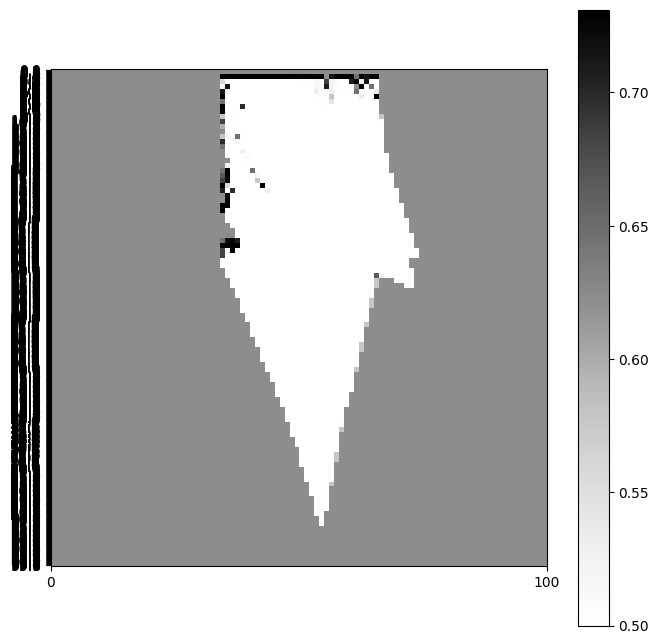

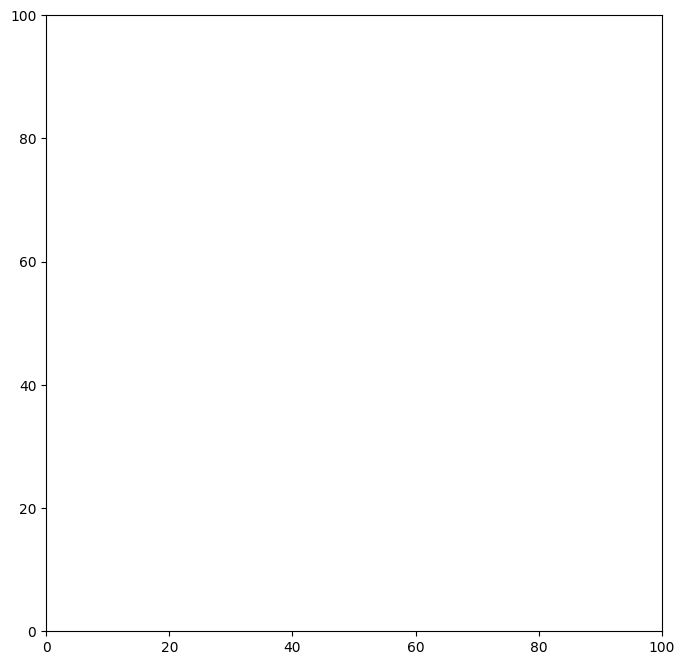

In [124]:
#plot_occupancy_grid(occ_grid)
plot_occupancy_grid(occupancy_grid, cols, rows, cell_size)
plot_laser_points(robot_controller.laser_points, robot_pos, robot_ori, map_size, cell_size)